[View in Colaboratory](https://colab.research.google.com/github/hyerim1048/100_pytorch/blob/master/pytorch_batchnorm.ipynb)

In [1]:
!pip3 install torch

    100% |████████████████████████████████| 484.0MB 23kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5c54a000 @  0x7fa2ab75a1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [2]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import init
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

torch.manual_seed(1)    # reproducible
np.random.seed(1)

In [3]:
# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = F.tanh
B_INIT = -0.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


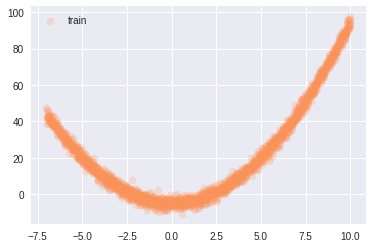

In [4]:
# 임의로 데이터 준비

# training data
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
test_x = Variable(torch.from_numpy(test_x).float(), volatile=True)  # not for computing gradients
test_y = Variable(torch.from_numpy(test_y).float(), volatile=True)

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')

In [0]:
## torch.nn.BatchNorm1d(num_features, eps=1e-05,momentum=0.1, affine=true, tracj_running_stats=True)

mini-batch마다 standard-deviation과 평균을 계산 한 후에 learnable gamma와 beta를 넣어줌.



In [10]:
for i in range(N_HIDDEN):               # build hidden layers and BN layers
  input_size = 1 if i == 0 else 10 # 처음에는 1 
  fc = nn.Linear(input_size, 10) # input size * 10 neural net
  print('fc%s' % i, fc)

fc0 Linear(in_features=1, out_features=10, bias=True)
fc1 Linear(in_features=10, out_features=10, bias=True)
fc2 Linear(in_features=10, out_features=10, bias=True)
fc3 Linear(in_features=10, out_features=10, bias=True)
fc4 Linear(in_features=10, out_features=10, bias=True)
fc5 Linear(in_features=10, out_features=10, bias=True)
fc6 Linear(in_features=10, out_features=10, bias=True)
fc7 Linear(in_features=10, out_features=10, bias=True)


In [14]:
class Net(nn.Module):
    def __init__(self, batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)   # 1d input batch norm

        for i in range(N_HIDDEN):               # build hidden layers and BN layers
            input_size = 1 if i == 0 else 10 # 처음에는 1 
            fc = nn.Linear(input_size, 10) # input size * 10 neural net
            setattr(self, 'fc%i' % i, fc)       # fc%i : type int 로 0 ~ 9까지 이름을 붙임
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

        self.predict = nn.Linear(10, 1)         # output layer
        self._set_init(self.predict)      
            
    def _set_init(self, layer):
        init.normal_(layer.weight, mean=0., std=.1) # normal ->>  normal_ 함수로 대체
        init.constant_(layer.bias, B_INIT)
          

    def forward(self, x):
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # 여기서 input에 batch normalization
        layer_input = [x]
        for i in range(N_HIDDEN): # Hidden State크기 만큼
            x = self.fcs[i](x) #
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out, layer_input, pre_activation

In [15]:
nets = [Net(batch_normalization=False), Net(batch_normalization=True)] # batchnorm  False and True

In [16]:
opts = [torch.optim.Adam(net.parameters(), lr=LR) for net in nets]

loss_func = torch.nn.MSELoss()

In [0]:
f,  axs  =  plt.subplots(4, N_HIDDEN+1, figsize=(10, 5))
plt.ion()  
def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax,  ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0: p_range = (-7, 10);the_range = (-7, 10)
        else:p_range = (-4, 4);the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].data.numpy().ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5);ax_pa_bn.hist(pre_ac_bn[i].data.numpy().ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].data.numpy().ravel(), bins=10, range=the_range, color='#FF9359');ax_bn.hist(l_in_bn[i].data.numpy().ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]: a.set_yticks(());a.set_xticks(())
        ax_pa_bn.set_xticks(p_range);ax_bn.set_xticks(the_range)
        axs[0, 0].set_ylabel('PreAct');axs[1, 0].set_ylabel('BN PreAct');axs[2, 0].set_ylabel('Act');axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)
